# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

In [1]:
!pip3 install pandas
!pip3 install plotly
!pip3 install numpy
!pip3 install seaborn
!pip3 install matplotlib.pyplot
!pip3 install mpl_toolkits
!pip3 install sklearn
!pip3 install statsmodels
!pip3 install random

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user install

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

## Goal: to identify what consumers value in a used car / what determines car value? 

### Questions:
* What types of quantitative and qualitative features impacts the value of a car? 
* Do newer cars always have a higher value?
* What realistic weightages can be applied to each category to calculate a price?

In this analysis we will take a look at what customers use to value cars or, in other words, what features can be correlated to having high importance to determine the price of a used car? 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

## Empty values 
* Are some columns entirely empty? 
* Are some columns only partially filled (majority of columns are empty)? If these fields are not needed, could they be removed from the analysis entirely? 


## Data types 
* Are fields currently expressed in the best possible data type? Could any strings (e.g. "isValid" an "isInvalid") be converted to numbers (0 and 1)

## Interpreting data 
* Would a certain column be better represented as numbers for future numerical analysis? 
* Would it be valuable to add any new columns which are based on calculation (e.g. fuel efficiency calculation) 
* Could any partially filled fields be propagated with values to use in analysis? If not, should they be removed? 
* Would any fields be better represented as the index for this dataset?

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from random import shuffle, seed

In [3]:
vehicles = pd.read_csv('data/vehicles.csv')
vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [4]:
# clean data
vehicles = vehicles.dropna()
vehicles.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al


In [5]:
# Unecessary information 
vehicles.drop('VIN', inplace=True, axis=1)

# Data types
vehicles['year'] = vehicles['year'].astype(int)
vehicles['odometer'] = vehicles['odometer'].astype(int)


vehicles.head(100)

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018,chevrolet,express cargo van,like new,6 cylinders,gas,68472,clean,automatic,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019,chevrolet,express cargo van,like new,6 cylinders,gas,69125,clean,automatic,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018,chevrolet,express cargo van,like new,6 cylinders,gas,66555,clean,automatic,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002,toyota,echo,excellent,4 cylinders,gas,155000,clean,automatic,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995,bmw,525i,fair,6 cylinders,gas,110661,clean,automatic,rwd,mid-size,sedan,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,7309581202,birmingham,8500,2008,lexus,es350,good,6 cylinders,gas,155374,clean,automatic,rwd,full-size,sedan,grey,al
1062,7309140128,birmingham,8950,2011,ford,f-150,excellent,6 cylinders,gas,164000,clean,automatic,fwd,full-size,truck,white,al
1095,7308717036,birmingham,14141,2017,ram,promaster city cargo van,like new,4 cylinders,gas,102386,clean,automatic,fwd,full-size,van,white,al
1096,7308711653,birmingham,18777,2016,volvo,s60 inscription platinum,like new,4 cylinders,gas,38561,clean,automatic,fwd,mid-size,sedan,silver,al


<AxesSubplot:>

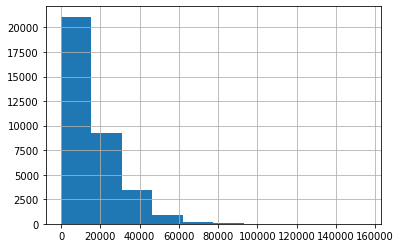

In [6]:
# understanding the current skew
vehicles['price'].hist()

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [7]:
# perform feature selection with target as price 
X = vehicles.drop('price', axis = 1)
y = vehicles["price"]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [9]:
# numerical analysis for: year and odometer
highest_corr = vehicles.corr()[['price']].nlargest(columns = 'price', n = 10)
print(highest_corr)

             price
price     1.000000
year      0.254059
id       -0.049819
odometer -0.199988


In [17]:
# categorical analysis for: condition, cylinders, paint_color, size, transmission (SEE: try it 8.1)
numerical_cols=['year','odometer']
categorical_cols=['manufacturer', 'model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']

numerical_transformer = SimpleImputer(strategy='constant')
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols), ('cat', categorical_transformer, categorical_cols)])

In [ ]:
# # linear regression model 
train_mses = []
test_mses = []
for i in range(1, 21):
    pipe = Pipeline([('preprocessor', preprocessor), ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                    ('linreg', LinearRegression())])
    pipe.fit(X_train, y_train)
    train_preds = pipe.predict(X_train)
    test_preds = pipe.predict(X_test)
    train_mses.append(mean_squared_error(y_train, train_preds))
    test_mses.append(mean_squared_error(y_test, test_preds))

best_model_complexity = test_mses.index(min(test_mses)) + 1

print("best complexity: ", best_complexity)


In [19]:
#Calculate permutation feature importance
model = LinearRegression()
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)])
pipeline.fit(X_train, y_train)

#Calculate permutation feature importance
Permutation = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)

In [20]:
importance = pd.DataFrame({'Column': X_test.columns,
                              'Importance': Permutation.importances_mean})
importance = importance.sort_values(by='Importance', ascending=False)
importance = importance.reset_index(drop=True)
print(importance)

          Column  Importance
0          model    0.337058
1           year    0.176001
2   manufacturer    0.076474
3           type    0.051845
4           fuel    0.048711
5      condition    0.024417
6          drive    0.023791
7           size    0.023722
8       odometer    0.022330
9   transmission    0.016854
10     cylinders    0.007934
11   paint_color    0.003331
12  title_status    0.001890
13            id    0.000000
14        region    0.000000
15         state    0.000000


In [27]:
# Cross validation 
def simple_cross_validation(X_train, y_train, X_test, y_test):
    best_pipe = None 
    best_mse = np.inf 
    for i in range(1, 21):
        pipe = Pipeline([('preprocessor', preprocessor), ('pfeat', PolynomialFeatures(degree = i, include_bias=False)), 
                    ('linreg', LinearRegression())])
        pipe.fit(X_train, y_train)
        test_preds = pipe.predict(X_test)
        test_mse = mean_squared_error(y_test, test_preds)
        if test_mse < best_mse:
            best_mse = test_mse
            best_pipe = pipe
    return best_pipe

In [32]:
best_model = simple_cross_validation(X_train, y_train, X_test, y_test)
print(best_model.get_params())

KeyboardInterrupt: 

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

In [ ]:
# 0          model    0.337058
# 1           year    0.176001
# 2   manufacturer    0.076474
# 3           type    0.051845
# 4           fuel    0.048711
# 5      condition    0.024417
# 6          drive    0.023791
# 7           size    0.023722
# 8       odometer    0.022330
# 9   transmission    0.016854
# 10     cylinders    0.007934
# 11   paint_color    0.003331
# 12  title_status    0.001890

## Results 

#### In this analysis, we transformed all non-numerical fields (also called categorical fields) using a transformer, then analyzed all features against one another and ranked them by importance. 

#### Primary features
* Model (the cars model)
* Year (the year of the cars model, or how new the car is) 
* Manufacturer (the company that manufactured the car or the car brand) 

#### Secondary features
* Type (whether the car is a van, sedan, or other)
* Fuel (type of fuel used) 

#### Unimportant features 
* Region and state were not at all correlated to customer value
* Title status (whether the car has been damaged or is visibly damaged). This is likely not a large concern because customers are aware that the car is used or that minor repairs can be made relatively easily 
* Paint color was likely seen as unimportant as it can be changed relatively easily (instead of features such as type and fuel used by the car which are not in control of the customer). 


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

## Overview 

We can start by looking at the general distribution of prices for used cars. As you can see, the prices are skewed towards the left (lower prices) specifically under ~$18k. Our goal is to understand what plays into a customers decision comfort level with various price points - aka. what customers value in a car.

<AxesSubplot:>

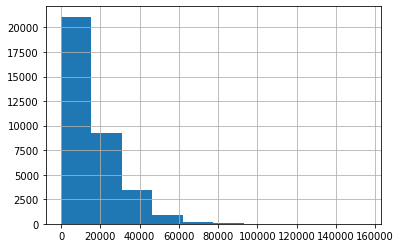

In [34]:
vehicles['price'].hist()

## Recommendations 
#### We can see from the results above that the top 3 most important features valued by customers that are directly correlated to price are: 
* Model (the cars model)
* Year (the year of the cars model, or how new the car is) 
* Manufacturer (the company that manufactured the car or the car brand) 

#### We can identify which models, years, and manufacturers were most sold to provide recommendations for your user car dealerhsip
We can show an example of this by looking at the value of prices for varying car models made in different years. 

In [43]:
px.bar(vehicles, x='year',y='price', title='Year of cars against the price',color_continuous_scale = 'viridis', barmode='stack')

#### We can see from the above graph that some of the most valued car year models are: 
* 2015 models with the highest total value for price  
* relatively skewed right because newer models are intuitively valued higher